In [10]:
from fractions import Fraction
from enum import Enum
from scipy.stats import binom
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class Reroll(Enum):
    ones = 1
    every = 2

In [12]:
from scipy.stats import binom
from fractions import Fraction
from enum import Enum

class Reroll(Enum):
    ones = 1
    every = 2

def approx_fraction(f):
    return f.numerator / f.denominator

def calc_prob(base_prop_numerator, modifier=0, rerolls=None, always_success_on=None):
    modifier = max(-1, min(1, modifier)) # clamp to [-1, 1]
    prob_success_numerator = max(1, min(5, base_prop_numerator + modifier))
    prob_success = Fraction(prob_success_numerator, 6)
    if (always_success_on):
        prob_success = max(prob_success, Fraction(6 - (always_success_on - 1), 6))
    if rerolls == Reroll.ones:
        prob_success = prob_success + Fraction(1, 6) * prob_success
    if rerolls == Reroll.every:
        prob_success = prob_success + Fraction(6 - prob_success_numerator, 6) * prob_success
    return prob_success

def p_hit(skill, modifier=0, rerolls=None, always_hit_on=None):
    p_hit_numerator = 6 - (skill - 1)
    return calc_prob(p_hit_numerator, modifier, rerolls, always_hit_on)

def get_wound_numerator(strength, toughness):
    if strength >= 2 * toughness:
        return 5
    if strength > toughness:
        return 4
    if strength == toughness:
        return 3
    if strength * 2 <= toughness:
        return 1
    if strength < toughness:
        return 2

def p_wound(strength, toughness, modifier=0, rerolls=None, always_wound_on=None):
    """
        Return the probability of wounding.
        Strength is the strength of the attack,
        Toughness is the toughness of receiver,
        always_wound_on returns just the probability of (always_wound_on - 1) / 6
    """
    p_wound_numerator = get_wound_numerator(strength, toughness)
    return calc_prob(p_wound_numerator, modifier, rerolls, always_wound_on)

def p_not_saved(armor_save, ap=None, invulnerable_save=None, modifier=0, rerolls=None):
    """
        Return the probability of wound going through armor.
        ap is positive integer
    """
    if not armor_save:
        return 1
    save = armor_save
    if ap:
        save = armor_save + ap
    if invulnerable_save and save > invulnerable_save:
        save = invulnerable_save
    modified_save = save
    if modifier:
        modified_save = modified_save - modifier
    if modified_save > 6:
        return 1
    save_succeeds_numerator = 6 - (save - 1)
    return 1 - calc_prob(save_succeeds_numerator, modifier, rerolls)


def calc_distribution(
    skill,
    strength,
    toughness,
    armor_save=None,
    ap=0,
    invulnerable_save=None,
    hit_modifier=0,
    wound_modifier=0,
    armor_save_modifier=0,
    hit_rerolls=None,
    wound_rerolls=None,
    armor_rerolls=None,
    always_hit_on=None,
    always_wound_on=None
    ):
    prob_hit = p_hit(skill, hit_modifier, hit_rerolls, always_hit_on)
    prob_wound = p_wound(strength, toughness, wound_modifier, wound_rerolls, always_wound_on)
    prob_not_saved = p_not_saved(armor_save, ap, invulnerable_save, armor_save_modifier, armor_rerolls)
    return approx_fraction(prob_hit * prob_wound * prob_not_saved)


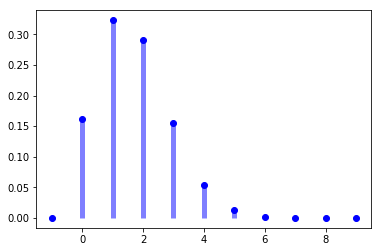

In [35]:
p = calc_distribution(3, 4, 4, armor_save=4)
n = 10

x = np.arange(binom.ppf(0, n, p), binom.ppf(1, n, p))
fig, ax = plt.subplots(1, 1)
ax.plot(x, binom.pmf(x, n, p), 'bo')
ax.vlines(x, 0, binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
#ax.title = "5 Dire Avengers vs Necron warriors"
ax.ylabel = "p"
ax.xlabel = "wounds" 
plt.show()

10.0